## **TASK 1** : **data preprocessing**
#### Load and explore the dataset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ## dataset loading
# from google.colab import files
# uploaded = files.upload()

In [3]:
## dataset exploration
import pandas as pd
data = pd.read_csv('/content/carseats.csv')
display(data.head())

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120.0,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83.0,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80.0,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97.0,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128.0,Bad,38,13,Yes,No


#### **Q1.a** How many numerical features are there? How many categorical features?

#### **ANSWER**: 
The dataset consists in 7 numerical and 3 categorical features. The target is numerical (hence the task is a regression task).

#### **Q1.b** Verify if the dataset presents missing values and handle them

In [4]:
## check the presence and eventually handle missing values
data.describe(include="all")

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
count,400.000000,400.000000,400.000000,400.000000,400.000000,397.000000,398,400.000000,400.000000,400,400
unique,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,Medium,NaN,NaN,Yes,Yes
freq,NaN,NaN,NaN,NaN,NaN,NaN,217,NaN,NaN,282,258
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.821159,NaN,53.322500,13.900000,NaN,NaN
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.660493,NaN,16.200297,2.620528,NaN,NaN
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,NaN,25.000000,10.000000,NaN,NaN
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,NaN,39.750000,12.000000,NaN,NaN
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,NaN,54.500000,14.000000,NaN,NaN
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,NaN,66.000000,16.000000,NaN,NaN


In [5]:
data.isnull().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          3
ShelveLoc      2
Age            0
Education      0
Urban          0
US             0
dtype: int64

In [6]:
data.shape

(400, 11)

In [7]:
data.drop_duplicates(inplace = True)
data.dropna(inplace = True)

In [8]:
X = data.drop('Sales', axis = 1)
y = data.Sales

#### **Q1.c** Justify the choises you make for handling missing values 
#### **ANSWER**: 
<< There are 5 missing values on columns Price and ShelveLoc. There might be different options for handling this missing values: filling with an aggregated value is a good option. I dropped the rows with missing values: this most probably will not impact the performances of the trained model, since we are slightly descreasing the dimention of the datset. >>

## **TASK 2 : data engineering**
Prepare the dataset for a Linear Regression task

#### **Q2.a** Verify the values distribution of the numerical variables.

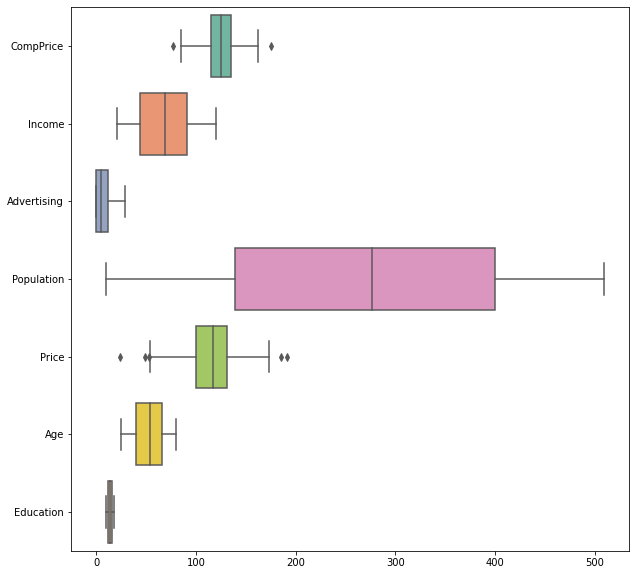

In [9]:
## variables distribution visualization
import seaborn as sns
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=X, orient="h", palette="Set2")


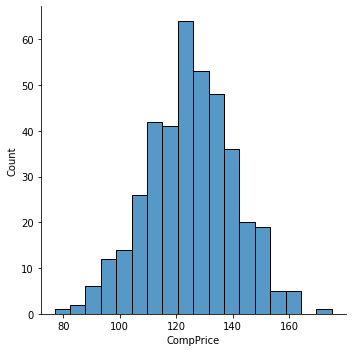

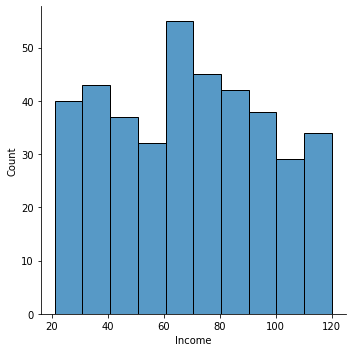

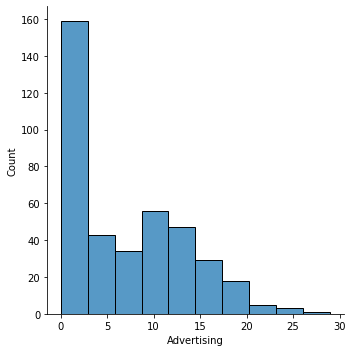

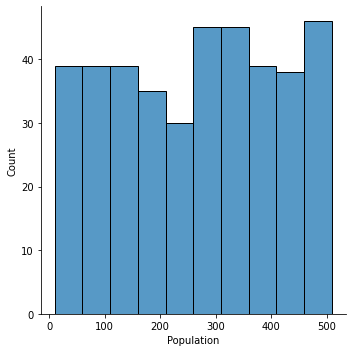

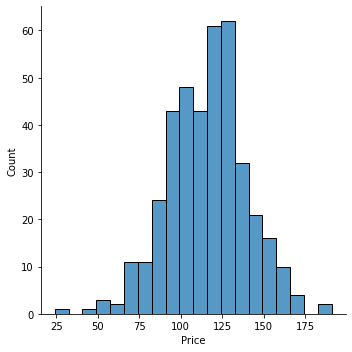

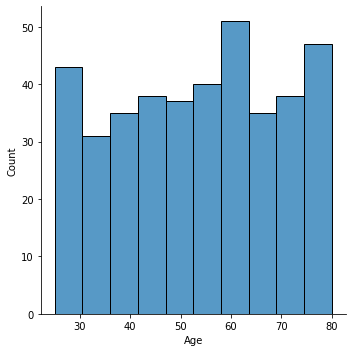

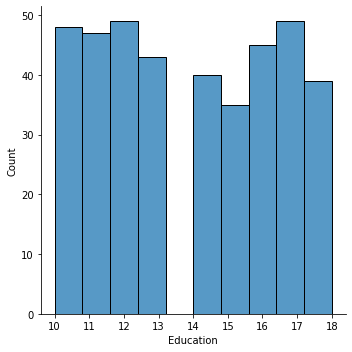

In [10]:
X_numerics = X.select_dtypes(exclude = 'object')
for column in X_numerics.columns:
  sns.displot(X[column])
  plt.show()

#### **Q2.b** Is features transformation necessary for the numerical variables? Let's take into account we are preparing the dataset for a Linear Regression task, with the goal to build a "Sales" predictive model. If transformation is necessary, after justifying your choice, do proceed as described.

#### **ANSWER**:  
<< We might need to transform the "Advertising" feature which follows a Poisson distribution: a log transform might help. Additionally, all features need to be scaled: the Gradinet Descent procedure which is at the base of the model training will benefit from this transformation. I will apply a Robust Scaler, in order not to get influences by eventual outliers in the scaling process. >>


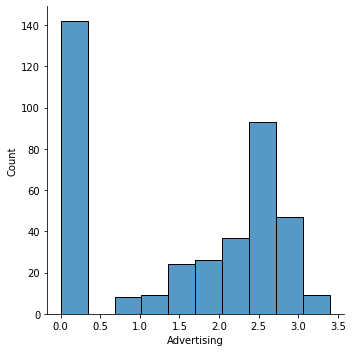

In [11]:
X['Advertising'] = np.log(X['Advertising'].values + 1)
sns.displot(X['Advertising'])

In [12]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(X_numerics)
X_numerics_scaled = transformer.transform(X_numerics)

In [13]:
X[X_numerics.columns]=X_numerics_scaled

#### **Q2.c** Verify the presence of outliers and eventually handle them

In [14]:
## Check the presence and eventually handle outliers

from scipy import stats
len(X_numerics_scaled[(np.abs(stats.zscore(X_numerics_scaled)) > 2.5).all(axis = 1)])

0

Using z-score to identify outliers with a threshold of 2.5, we do not identify outliers in the dataset.

#### **Q2.d** Is encoding necessary for all the categorical variables? Which kind of encoding? Please do specify your chioices, justify them and perform cathegorical data encodign in the code cell below. 

#### **ANSWER HERE**:
<< Categorical variables need to be encoded and converted into numbers. Both "Urban" and "US" columns values are either Yes or No, hence might be encoded as boolean respectively as 1/0. A Label Encoder can be used. 

Column "ShelveLoc" can assume different values [Bad, Medium, Good]. Since these values have a semantical order, we might Label Encode them as [0,1,2] for example (keeping the right values order) or we can One-Hot-Encode the values (this is what I will do below). >>

In [15]:
## perform cathegorical variables encoding here
X_cat = X.select_dtypes(include = 'object')
X_cat.head()

,ShelveLoc,Urban,US
0,Bad,Yes,Yes
1,Good,Yes,Yes
2,Medium,Yes,Yes
3,Medium,Yes,Yes
4,Bad,Yes,No


In [16]:
# from sklearn.preprocessing import 

# oe = OrdinalEncoder(categories={'Bad': -1, 'Medium': 0, 'Good': 1})
# X["ShelveLoc"] = oe.fit_transform(X["ShelveLoc"])
# display(X)

In [17]:
X = pd.get_dummies(X) 

In [18]:
X.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
0,0.65,0.085106,0.500000,0.000000,0.096774,-0.452830,0.75,1,0,0,0,1,0,1
1,-0.70,-0.446809,0.916667,-0.061420,-1.096774,0.415094,-1.00,0,1,0,0,1,0,1
2,-0.60,-0.723404,0.416667,-0.026871,-1.193548,0.188679,-0.50,0,0,1,0,1,0,1
3,-0.40,0.659574,-0.083333,0.729367,-0.645161,0.037736,0.00,0,0,1,0,1,0,1
4,0.80,-0.106383,-0.166667,0.245681,0.354839,-0.603774,-0.25,1,0,0,0,1,1,0


#### **Q2.e** --> Increase the dimentionality of the dataset introducing Polinomials -- degree = 3 (continuous variables)

In [19]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False) 
poly.fit(X[X_numerics.columns])
poly_values = poly.transform(X[X_numerics.columns])

In [20]:
poly_values.shape

(395, 119)

In [21]:
poly_features_df = pd.DataFrame(data=poly_values, columns=poly.get_feature_names_out())
X_poly_full = X[X.columns.difference(X_numerics.columns)]
X_poly_full = pd.concat([X_poly_full.reset_index(),poly_features_df.reset_index()], axis=1, ignore_index=True)
X_poly_full.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0,1,0,0,0,1,0,1,0,0.65,0.085106,0.500000,0.000000,0.096774,-0.452830,0.75,0.4225,0.055319,0.325000,0.000000,0.062903,-0.294340,0.4875,0.007243,0.042553,0.000000,0.008236,-0.038539,0.063830,0.250000,0.000000,0.048387,-0.226415,0.375000,0.000000,0.000000,-0.000000,0.000000,0.009365,-0.043822,...,-0.003730,0.006177,0.017452,-0.028904,0.047872,0.125000,0.000000,0.024194,-0.113208,0.187500,0.000000,0.000000,-0.000000,0.000000,0.004683,-0.021911,0.036290,0.102528,-0.169811,0.281250,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000906,-0.004241,0.007024,0.019844,-0.032867,0.054435,-0.092855,0.153791,-0.254717,0.421875
1,1,0,1,0,0,1,0,1,1,-0.70,-0.446809,0.916667,-0.061420,-1.096774,0.415094,-1.00,0.4900,0.312766,-0.641667,0.042994,0.767742,-0.290566,0.7000,0.199638,-0.409574,0.027443,0.490048,-0.185468,0.446809,0.840278,-0.056302,-1.005376,0.380503,-0.916667,0.003772,0.067364,-0.025495,0.061420,1.202914,-0.455265,...,0.203416,-0.490048,-0.076987,0.185468,-0.446809,0.770255,-0.051610,-0.921595,0.348795,-0.840278,0.003458,0.061751,-0.023371,0.056302,1.102671,-0.417326,1.005376,0.157945,-0.380503,0.916667,-0.000232,-0.004138,0.001566,-0.003772,-0.073883,0.027963,-0.067364,-0.010583,0.025495,-0.061420,-1.319325,0.499323,-1.202914,-0.188978,0.455265,-1.096774,0.071522,-0.172303,0.415094,-1.000000
2,2,0,0,1,0,1,0,1,2,-0.60,-0.723404,0.416667,-0.026871,-1.193548,0.188679,-0.50,0.3600,0.434043,-0.250000,0.016123,0.716129,-0.113208,0.3000,0.523314,-0.301418,0.019439,0.863418,-0.136491,0.361702,0.173611,-0.011196,-0.497312,0.078616,-0.208333,0.000722,0.032072,-0.005070,0.013436,1.424558,-0.225198,...,0.162909,-0.431709,-0.025753,0.068246,-0.180851,0.072338,-0.004665,-0.207213,0.032757,-0.086806,0.000301,0.013363,-0.002113,0.005598,0.593566,-0.093832,0.248656,0.014833,-0.039308,0.104167,-0.000019,-0.000862,0.000136,-0.000361,-0.038280,0.006051,-0.016036,-0.000957,0.002535,-0.006718,-1.700279,0.268784,-0.712279,-0.042490,0.112599,-0.298387,0.006717,-0.017800,0.047170,-0.125000
3,3,0,0,1,0,1,0,1,3,-0.40,0.659574,-0.083333,0.729367,-0.645161,0.037736,0.00,0.1600,-0.263830,0.033333,-0.291747,0.258065,-0.015094,-0.0000,0.435038,-0.054965,0.481072,-0.425532,0.024890,0.000000,0.006944,-0.060781,0.053763,-0.003145,-0.000000,0.531976,-0.470559,0.027523,0.000000,0.416233,-0.024346,...,-0.016058,-0.000000,0.000939,0.000000,0.000000,-0.000579,0.005065,-0.004480,0.000262,0.000000,-0.044331,0.039213,-0.002294,-0.000000,-0.034686,0.002029,0.000000,-0.000119,-0.000000,-0.000000,0.388005,-0.343210,0.020075,0.000000,0.303587,-0.017757,-0.000000,0.001039,0.000000,0.000000,-0.268537,0.015707,0.000000,-0.000919,-0.000000,-0.000000,0.000054,0.000000,0.000000,0.000000
4,4,1,0,0,1,0,0,1,4,0.80,-0.106383,-0.166667,0.245681,0.354839,-0.603774,-0.25,0.6400,-0.085106,-0.133333,0.196545,0.283871,-0.483019,-0.2000,0.011317,0.017730,-0.026136,-0.037749,0.064231,0.026596,0.027778,-0.040947,-0.059140,0.100629,0.041667,0.060359,0.087177,-0.148336,-0.061420,0.125911,-0.214242,...,0.022792,0.009437,-0.038781,-0.016058,-0.006649,-0.004630,0.006824,0.009857,-0.016771,-0.006944,-0.010060,-0.014530,0.024723,0.010237,-0.020985,0.035707,0.014785,-0.060757,-0.025157,-0.010417,0.014829,0.021418,-0.036443,-0.015090,0.030934,-0.052635,-0.021794,0.089561,0.037084,0.015355,0.044678,-0.076021,-0.031478,0.129354,0.053561,0.022177,-0.220101,-0.091136,-0.037736,-0.015625


## TASK 3: features selection

#### **Q3.a** Perform Automatic Features Selection and visualize the Features which have been selected. Select one appropriate methodology for features selection and justify your choice.

#### **ANSWER HERE**:
<< We might decide to use both univariate feature selection or model based feature selection. Below I am applying Recursive Feature Elimination and I am selecting the best 20 features. RFE select features by recursively considering smaller and smaller sets of features, eliminating at each iteration, the least significant features. To perform this methodology, I will exploit a regression methodologies which allows features ranking: RandomForestRegressor >>


In [22]:
# RFE=Feature ranking with recursive feature elimination.
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

select = RFE(RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=20)

select.fit(poly_values, y)

RFE(estimator=RandomForestRegressor(random_state=42), n_features_to_select=20)

In [23]:
mask = select.get_support()
features_names=poly.get_feature_names_out()
features_names[mask]

array(['Advertising', 'Price', 'CompPrice Income', 'CompPrice^3',
       'CompPrice^2 Age', 'CompPrice Advertising^2', 'CompPrice Age^2',
       'CompPrice Education^2', 'Income^2 Price', 'Income Advertising^2',
       'Income Price Education', 'Advertising^2 Price',
       'Advertising^2 Age', 'Advertising Population^2',
       'Population^2 Price', 'Price^3', 'Price^2 Age', 'Price Age^2',
       'Price Education^2', 'Age^3'], dtype=object)

Among the 20 most important features we have: "Advertising", and some interactions features including "CompPrice". 

In [24]:
poly_features_reduced_df = pd.DataFrame(data=poly_values[:,mask], columns=features_names[mask])

In [25]:
X_poly_reduced = X[X.columns.difference(X_numerics.columns)]
X_poly_reduced = pd.concat([X_poly_reduced.reset_index(),poly_features_reduced_df.reset_index()], axis=1, ignore_index=True)
X_poly_reduced.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,0,1,0,0,0,1,0,1,0,0.500000,0.096774,0.055319,0.274625,-0.191321,0.162500,0.133286,0.365625,0.000701,0.021277,0.006177,0.024194,-0.113208,0.000000,0.000000,0.000906,-0.004241,0.019844,0.054435,-0.092855
1,1,0,1,0,0,1,0,1,1,0.916667,-1.096774,0.312766,-0.343000,0.203396,-0.588194,-0.120612,-0.700000,-0.218958,-0.375443,-0.490048,-0.921595,0.348795,0.003458,-0.004138,-1.319325,0.499323,-0.188978,-1.096774,0.071522
2,2,0,0,1,0,1,0,1,2,0.416667,-1.193548,0.434043,-0.216000,0.067925,-0.104167,-0.021360,-0.150000,-0.624600,-0.125591,-0.431709,-0.207213,0.032757,0.000301,-0.000862,-1.700279,0.268784,-0.042490,-0.298387,0.006717
3,3,0,0,1,0,1,0,1,3,-0.083333,-0.645161,-0.263830,-0.064000,0.006038,-0.002778,-0.000570,-0.000000,-0.280670,0.004580,-0.000000,-0.004480,0.000262,-0.044331,-0.343210,-0.268537,0.015707,-0.000919,-0.000000,0.000054
4,4,1,0,0,1,0,0,1,4,-0.166667,0.354839,-0.085106,0.512000,-0.386415,0.022222,0.291634,0.050000,0.004016,-0.002955,0.009437,0.009857,-0.016771,-0.010060,0.021418,0.044678,-0.076021,0.129354,0.022177,-0.220101


## TASK 4: Linear Regression

#### **Q4.a** (OPTIONAL) Train a Multiple Linear Regression model, using the Sklearn implementation of Linear Regression to find the best $\theta$ vector. Use all the transformed features, excluding the derived polynomial features. Evaluate the model. Justify your choices with respect to the evaluation metrics exploited and discuss the obtained performance values.

In [26]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [27]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
y_pred_train = lin_reg.predict(X_train)

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("Test RMSE = {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("Test R2 = {}".format(r2_score(y_test, y_pred)))

print("Train RMSE = {}".format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print("Train R2 = {}".format(r2_score(y_train, y_pred_train)))

Test RMSE = 1.0382885774104713
Test R2 = 0.8563917945322044
Train RMSE = 0.9785709987467746
Train R2 = 0.8783653938409357


The metrics exploited to evaluate the Regression Model are the RMSE and the R2 score. The RMSE calculated over the test set is slightly higer than the one calculated over the train. Additionally, the R2 score tells us we are explaining 85% of the variance of the target variable. THis values tell us the model is not overfitting the data. However, we might do better. 

#### **Q2.b** Use all the transformed features,excluding the derived polynomial features,to identify the best values of $\theta$ by means of a Batch Gradient Descent Procedure. Identify the best values of $\eta$ (starting with an initial value of $\eta = 0.1$ ) and a fixed number of iterations = $1000$ . Evaluate the model with the trained $\theta$ . Justify your choices with respect to the evaluation metrics exploited and discuss the obtained performances values.


In [29]:
## Train a Multiple Linear Regression Model and evaluate it
eta_values = np.linspace(0.01, 0.8, num=20) # learning rate
n_iterations = 1000
m=X.shape[0]

for eta in eta_values:  
  print("\neta = {}".format(eta))
  theta = np.random.randn(X.shape[1]+1,1)  # random initialization

  X_b_train = np.c_[np.ones((len(X_train), 1)), X_train] # add x0 = 1 to each instance
  y_train = np.array(y_train)

  for iteration in range(n_iterations):
    gradients = 2/m * X_b_train.T.dot(X_b_train.dot(theta) - y_train.reshape(-1,1))
    theta = theta - eta * gradients
  
  X_b_test = np.c_[np.ones((len(X_test), 1)), X_test] # add x0 = 1 to each instance
  y_predict = X_b_test.dot(theta)

  print("Test RMSE={}".format(np.sqrt(mean_squared_error(y_test, y_predict))))
  print("Test R2={}".format(r2_score(y_test, y_predict)))   


eta = 0.01
Test RMSE=1.055462996130249
Test R2=0.8516016314357632

eta = 0.05157894736842106
Test RMSE=1.0418974297804329
Test R2=0.8553917613975708

eta = 0.0931578947368421
Test RMSE=1.0418253263881831
Test R2=0.8554117756205963

eta = 0.13473684210526318
Test RMSE=1.0418253183166966
Test R2=0.8554117778609756

eta = 0.17631578947368423
Test RMSE=1.0418253178695147
Test R2=0.8554117779850985

eta = 0.21789473684210528
Test RMSE=1.0418253178694394
Test R2=0.8554117779851194

eta = 0.25947368421052636
Test RMSE=1.0418253178694374
Test R2=0.8554117779851199

eta = 0.3010526315789474
Test RMSE=1.0418253178694374
Test R2=0.8554117779851199

eta = 0.34263157894736845
Test RMSE=1.0418253178694374
Test R2=0.8554117779851199

eta = 0.3842105263157895
Test RMSE=1.0418253178694374
Test R2=0.8554117779851199

eta = 0.42578947368421055
Test RMSE=1.0418253178694374
Test R2=0.8554117779851199

eta = 0.4673684210526316
Test RMSE=1.0418253178694377
Test R2=0.8554117779851199

eta = 0.508947368421052

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:427: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:790: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:427: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:790: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:427: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weigh

ValueError: ignored

We achieve the best performances with eta = 0.5. Performance are evaluates as above by means of the r2 (target variable explained variace) and RMSE.

r2= 85% and RMSE=1.04 Values comparable with the previous approach. 

#### **Q2.c** Use the complete set of features, including the derived polynomial features. Train a Multiple Linear Regression model, using the Sklearn implementation of Linear Regression to find the best θ vector. Evaluate the model.

In [ ]:
X_poly_full.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_poly_full, y, random_state=1) 

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
y_pred_train = lin_reg.predict(X_train)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("Test RMSE = {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("Test R2 = {}".format(r2_score(y_test, y_pred)))

print("Train RMSE = {}".format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print("Train R2 = {}".format(r2_score(y_train, y_pred_train)))

The model is performing worst than the previous ones. It is performing better on the train set, and worst in the test set. It seems the model is overfitting the data. 

#### **Q2.d** Use the complete set of features, including the derived polynomial features. Train a Ridge Regression model identifying the best value of α that allows the model to achieve the best generalization performances.

In [ ]:
from sklearn.linear_model import Ridge

alpha_values = [0,0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1, 2, 5, 10]

for alpha in alpha_values:
  print("\nalpha = {}".format(alpha))
  ridge_reg = Ridge(alpha=alpha, solver="cholesky")
  ridge_reg.fit(X_train, y_train)

  y_pred = ridge_reg.predict(X_test)
  y_pred_train = lin_reg.predict(X_train)

  print("Test RMSE = {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
  print("Test R2 = {}".format(r2_score(y_test, y_pred)))

  print("Train RMSE = {}".format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
  print("Train R2 = {}".format(r2_score(y_train, y_pred_train)))

Regularizing with a Ridge and a value of alpha =5, we gratly increase the generalizatio performances of the linear model, achieving a test r2-score of 82% (75% for plain regression without regularization). 

#### **Q2.e** (OPTIONAL) Use the subset of features selected in the Feature Selection task set. Train a Multiple Linear Regression model using the Sklearn implementation of Linear Regression to find the best θ vector. Evaluate the model and compare the results with the approach exploited in the previous task.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_poly_reduced, y, random_state=1) 

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
y_pred_train = lin_reg.predict(X_train)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("Test RMSE = {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("Test R2 = {}".format(r2_score(y_test, y_pred)))

print("Train RMSE = {}".format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print("Train R2 = {}".format(r2_score(y_train, y_pred_train)))

The model trained on the selected subset of relevant features is performing even slightly worst than the regular Linear Regression model on the complete set of features. This means the selected data is not enought to learn a model. We might increare the number of selected features on the feature selection phase. 

#### **Q2.f** Compare and discuss the results obtained above

Summary of the obtained results:
* Linear Regression with original preprocessed features 
> Test RMSE = 1.0418253178694377 \\
 Test R2 = 0.8554117779851199
* Gradient Descent with original preprocessed features, with optimal $\eta = 0.5$
>Test RMSE=1.0418253178694374 \\
Test R2=0.8554117779851199
* Linear Regression with all original and polynomial features 
> Test RMSE = 1.3515654381768298 \\
Test R2 = 0.7566578963926919
* Ridge with all original and polynomial features, with optimal $\alpha = 5$
> Test RMSE = 1.1457326158565053 \\
Test R2 = 0.8251322767065665
* Linear Regression with categorical encoded features + selection of 20 most relevant polynomial features
> Test RMSE = 1.4283778620084424 \\
Test R2 = 0.7282125969085883

The model which perform best is the Linear Regression model trained on the original set of features preprocessed as follows:
- numerical scaled features (one transformed before scaling)
- categorical encoded features (boolean and one-hot)
